In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fit import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [5]:
def logistic(x, midpoint, steepness):
    return 1 / (1 + np.exp(-steepness * (x - midpoint)))

def logistic_derivative(x, midpoint, steepness):
    exp_term = np.exp(-steepness * (x - midpoint))
    return (steepness * exp_term) / ((1 + exp_term) ** 2)

In [26]:
def get_switches(data):
    columns = ['type', 'sid', 'trial', 'stage', 'conflict', 'switch', 'switches']
    dfs = []
    human = pd.read_pickle(f"data/jiang.pkl")
    model_type = data['type'].unique()[0]
    for sid in human['sid'].unique():
        print(f"sid {sid}")
        for trial in data.query("sid==@sid")['trial'].unique():
            A_old = data.query("sid==@sid & trial==@trial & stage==0")['action'].to_numpy()[0]
            switches = 0
            for stage in range(1, 4):
                A = data.query("sid==@sid & trial==@trial & stage==@stage")['action'].unique()[0]
                samples = data.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()
                n_consistent = len(np.where(samples==A_old)[0])
                n_inconsistent = len(np.where(samples!=A_old)[0])
                conflict = n_inconsistent / (n_consistent + n_inconsistent)
                if A!=A_old:
                    switch = 1
                    switches += 1
                else:
                    switch = 0
                    switches += 0   
                dfs.append(pd.DataFrame([[model_type, sid, trial, stage, conflict, switch, switches]], columns=columns))
                A_old = A
    data_add = pd.concat(dfs, ignore_index=True)
    # fit a logistic function to y=switch, x=conflict
    dfs2 = []
    columns2 = ['type', 'sid', 'midpoint', 'steepness', 'tangent']
    for sid in human['sid'].unique():
        x = data_add.query("sid==@sid")['conflict'].to_numpy()
        y = data_add.query("sid==@sid")['switch'].to_numpy()
        try:
            params, covariance = scipy.optimize.curve_fit(logistic, x, y, p0=[0.5, 1.0])
            deriv = logistic_derivative(params[0], params[0], params[1])
            dfs2.append(pd.DataFrame([[model_type, sid, params[0], params[1], deriv]], columns=columns2))
        except:
            print(f"missing {model_type} {sid}")
            continue
    logistic_fits = pd.concat(dfs2, ignore_index=True)
    return data_add, logistic_fits

In [27]:
a = pd.read_pickle("data/DG_z_jiang_mar7_dynamics.pkl")
a['type'] = "DeGroot"
degroot, degroot_logistic = get_switches(a)

b = pd.read_pickle("data/RL_z_jiang_mar7_dynamics.pkl")
b['type'] = "Reinforcement\nLearning"
rl, rl_logistic = get_switches(b)

c = pd.read_pickle("data/NEF_syn_jiang_apr18_dynamics.pkl")
c['type'] = "Neural\nNetwork"
nef, nef_logistic = get_switches(c)

d = pd.read_pickle("data/jiang.pkl")
d['type'] = 'Human'
human, human_logistic = get_switches(d)

combined = pd.concat([human, degroot, rl, nef], ignore_index=True)
combined_logistic = pd.concat([human_logistic, degroot_logistic, rl_logistic, nef_logistic], ignore_index=True)

sid 1
sid 2
sid 3
sid 4
sid 5
sid 6
sid 7
sid 8
sid 9
sid 10
sid 11
sid 12
sid 13
sid 14
sid 15
sid 16
sid 18
sid 19
sid 20
sid 21
sid 23
sid 24
sid 25
sid 26
sid 27
sid 28
sid 29
sid 30
sid 31
sid 32
sid 33
sid 34
sid 35
sid 36
sid 38
sid 39
sid 40
sid 41
sid 42
sid 43
sid 44
sid 45
sid 46
sid 47
sid 48
sid 49
sid 57
sid 58
sid 59
sid 60
sid 61
sid 62
sid 63
sid 64
sid 65
sid 66
sid 67
sid 68
sid 69
sid 70
sid 71
sid 72
sid 73
sid 74
sid 75
sid 76
sid 77
sid 78
sid 79
sid 80
sid 81
sid 82
sid 83
sid 84
sid 85
sid 86
sid 87
sid 88
sid 89
sid 90
sid 91
sid 92
sid 93
sid 94
sid 95
sid 96
sid 97
sid 98
sid 99
sid 101
sid 102
sid 103
sid 104
sid 106
sid 107
sid 108
sid 109
sid 110
sid 111
sid 112
sid 113
sid 114
sid 115
sid 116
sid 117
sid 118
sid 119
sid 120
sid 121
sid 122
sid 123
sid 124
sid 125
sid 126
sid 127
sid 128
sid 129
sid 130
sid 131
sid 132
sid 134
sid 135
sid 136
sid 137
sid 138
sid 140
sid 141
sid 142
sid 143
sid 144
sid 145
sid 146
sid 147
sid 148
sid 149
sid 151
sid 152
si

In [28]:
combined.to_pickle("data/switch_vs_conflict.pkl")
combined_logistic.to_pickle("data/switch_vs_conflict_logistic.pkl")

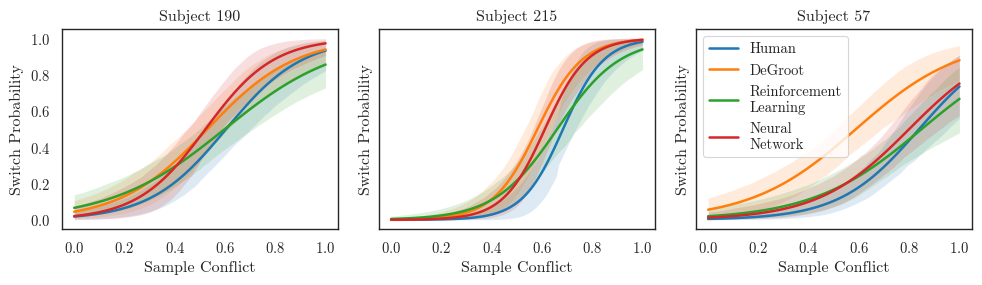

In [142]:
sid1 = 190
sid2 = 215
sid3 = 57
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=True, sharex=True)
for mt, model_type in enumerate(combined['type'].unique()):
    sns.regplot(combined.query("sid==@sid1 & type==@model_type"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[mt], ax=axes[0], label=model_type)
    sns.regplot(combined.query("sid==@sid2 & type==@model_type"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[mt], ax=axes[1], label=model_type)
    sns.regplot(combined.query("sid==@sid3 & type==@model_type"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[mt], ax=axes[2], label=model_type)
axes[0].set(ylabel="Switch Probability", xlabel="Sample Conflict", title=f"Subject {sid1}")
axes[1].set(ylabel="Switch Probability", xlabel="Sample Conflict", title=f"Subject {sid2}")
axes[2].set(ylabel="Switch Probability", xlabel="Sample Conflict", title=f"Subject {sid3}")
axes[2].legend()
# axes[0].get_legend().remove()
# axes[1].get_legend().remove()
plt.tight_layout()
plt.savefig("plots/switch_vs_conflict.jpg", dpi=600)

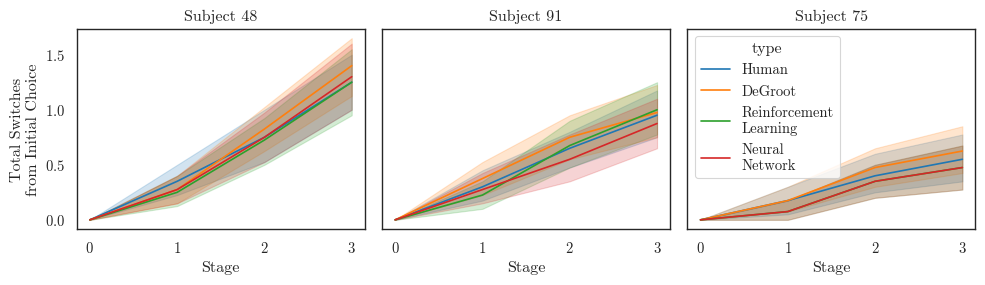

In [11]:
sid1 = 48
sid2 = 91
sid3 = 75
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=True, sharex=True)
sns.lineplot(combined.query("sid==@sid1"), x='stage', y='switches', hue='type', palette=palette[:4], ax=axes[0])
sns.lineplot(combined.query("sid==@sid2"), x='stage', y='switches', hue='type', palette=palette[:4], ax=axes[1])
sns.lineplot(combined.query("sid==@sid3"), x='stage', y='switches', hue='type', palette=palette[:4], ax=axes[2])
axes[0].set(ylabel="Total Switches\nfrom Initial Choice", xlabel="Stage", title=f"Subject {sid1}")
axes[1].set(ylabel="Total Switches\nfrom Initial Choice", xlabel="Stage", title=f"Subject {sid2}")
axes[2].set(ylabel="Total Switches\nfrom Initial Choice", xlabel="Stage", title=f"Subject {sid3}")
axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.tight_layout()
plt.savefig("plots/switches_vs_stage.jpg", dpi=600)

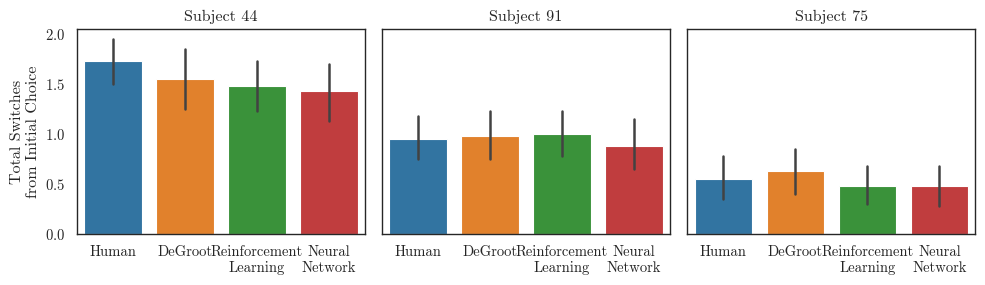

In [97]:
sid1 = 44
sid2 = 91
sid3 = 75
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=True, sharex=True)
# sns.kdeplot(combined.query("sid==@sid1 & stage==3"), x='switches', hue='type', cut=0, fill=True, common_norm=False, palette=palette[:4], ax=axes[0])
# sns.kdeplot(combined.query("sid==@sid2 & stage==3"), x='switches', hue='type', cut=0, fill=True, common_norm=False, palette=palette[:4], ax=axes[1])
# sns.kdeplot(combined.query("sid==@sid3 & stage==3"), x='switches', hue='type', cut=0, fill=True, common_norm=False, palette=palette[:4], ax=axes[2])
# axes[0].set(xlabel="Total Switches\nfrom Initial Choice", title=f"Subject {sid1}")
# axes[1].set(xlabel="Total Switches\nfrom Initial Choice", title=f"Subject {sid2}")
# axes[2].set(xlabel="Total Switches\nfrom Initial Choice", title=f"Subject {sid3}")
sns.barplot(combined.query("sid==@sid1 & stage==3"), y='switches', x='type', hue='type', palette=palette[:4], ax=axes[0])
sns.barplot(combined.query("sid==@sid2 & stage==3"), y='switches', x='type', hue='type', palette=palette[:4], ax=axes[1])
sns.barplot(combined.query("sid==@sid3 & stage==3"), y='switches', x='type', hue='type', palette=palette[:4], ax=axes[2])
axes[0].set(ylabel="Total Switches\nfrom Initial Choice", title=f"Subject {sid1}", xlabel=None)
axes[1].set(ylabel="Total Switches\nfrom Initial Choice", title=f"Subject {sid2}", xlabel=None)
axes[2].set(ylabel="Total Switches\nfrom Initial Choice", title=f"Subject {sid3}", xlabel=None)
plt.tight_layout()
plt.savefig("plots/switches_final_stage.jpg", dpi=600)

In [ ]:
conflict_bins = np.linspace(0, 1.0, 5)
g = sns.FacetGrid(human, col='sid', sharey=True, sharex=False, legend_out=False) # sharex='row'
g.map_dataframe(sns.regplot, x="conflict", y='switch', scatter=False, logistic=True, color=palette[0])
plt.tight_layout()
g.savefig("plots/switch_vs_conflict_all_sids.jpg", dpi=50)
plt.show()

# Run all models for one SID, varying one parameter

In [204]:
def run_and_get_switches(model_type, sid, beta, seed=0):
    human = pd.read_pickle(f"data/jiang.pkl").query("sid==@sid")
    trials = human['trial'].unique()
    stages = human['stage'].unique()
    rng = np.random.RandomState(seed=seed)
    columns = ['type', 'sid', 'beta', 'trial', 'stage', 'conflict', 'switch']
    dfs = []
    if model_type=='DG_z':
        p = pd.read_pickle("data/DG_z_jiang_mar7_params.pkl").query("sid==@sid")
        z = p['z'].unique()[0]
        beta = p['beta'].unique()[0]
        params = [z, beta]
    if model_type=='RL_z':
        p = pd.read_pickle("data/RL_z_jiang_mar7_params.pkl").query("sid==@sid")
        alpha = p['alpha'].unique()[0]
        beta = p['beta'].unique()[0]
        z = p['z'].unique()[0]
        params = [alpha, z, beta]
    if model_type=='NEF_syn':
        p = pd.read_pickle("data/NEF_syn_jiang_apr18_params.pkl")
        alpha = p['alpha'].unique()[0]
        beta = p['beta'].unique()[0]
        z = p['z'].unique()[0]
        lambd = p['lambda'].unique()[0]
        params = [beta]
        # NEF models must pre-run and save data before get_expectations_jiang can retrieve them
        data = run_NEF_syn("jiang", sid, alpha=alpha, z=z, lambd=lambd)
    for trial in trials:
        A_old = 0
        for stage in stages:
            samples = human.query("trial==@trial & stage==@stage")['color'].to_numpy()
            if model_type=='human':
                A = human.query("trial==@trial & stage==@stage")['action'].unique()[0]
            else:
                expectation = get_expectations_jiang(model_type, params, sid, trial, stage)
                prob = scipy.special.expit(beta*expectation)
                A = 1 if rng.uniform(0,1) < prob else -1
            if stage>0:
                n_consistent = len(np.where(samples==A_old)[0])
                n_inconsistent = len(np.where(samples!=A_old)[0])
                conflict = n_inconsistent / (n_consistent + n_inconsistent)
                switch = 1 if A!=A_old else 0
                dfs.append(pd.DataFrame([[model_type, sid, beta, trial, stage, conflict, switch]], columns=columns))
            A_old = A
    switch_data = pd.concat(dfs, ignore_index=True)
    # fit a logistic function to y=switch, x=conflict
    x = switch_data['conflict'].to_numpy()
    y = switch_data['switch'].to_numpy()
    params, covariance = scipy.optimize.curve_fit(logistic, x, y, p0=[0.5, 1.0])
    fit = pd.DataFrame([[model_type, sid, params[0], params[1]]], columns=['type', 'sid', 'midpoint', 'steepness'])
    return switch_data, fit

In [205]:
betas = [2, 3, 7]
# sids = [190, 215, 57]
sids = [40, 190, 215]
sid_for_params = 190

dfs = []
dfs2 = []
for sid in sids:
    switch, fit = run_and_get_switches("human", sid, None)
    dfs.append(switch)
    dfs2.append(fit)
human = pd.concat(dfs, ignore_index=True)
human_fit = pd.concat(dfs2, ignore_index=True)
human['type'] = "Human"
human_fit['type'] = "Human"

dfs = []
dfs2 = []
for sid in sids:
# for beta in betas:
    switch, fit = run_and_get_switches("DG_z", sid,  None)
    # switch, fit = run_and_get_switches("DG_z", sid_for_params, beta)
    dfs.append(switch)
    dfs2.append(fit)
degroot = pd.concat(dfs, ignore_index=True)
degroot_fit = pd.concat(dfs2, ignore_index=True)
# degroot['type'] = "DeGroot"
# degroot_fit['type'] = "DeGroot"

dfs = []
dfs2 = []
for sid in sids:
# for beta in betas:
    switch, fit = run_and_get_switches("RL_z", sid,  None)
    # switch, fit = run_and_get_switches("RL_z", sid_for_params, beta)
    dfs.append(switch)
    dfs2.append(fit)
rl = pd.concat(dfs, ignore_index=True)
rl_fit = pd.concat(dfs2, ignore_index=True)
# rl['type'] = "Reinforcement\nLearning"
# rl_fit['type'] = "Reinforcement\nLearning"

# dfs = []
# dfs2 = []
# for beta in betas:
#     switch, fit = run_and_get_switches("NEF_syn", sid_for_params, beta)
#     dfs.append(switch)
#     dfs2.append(fit)
# nef = pd.concat(dfs, ignore_index=True)
# nef_fit = pd.concat(dfs2, ignore_index=True)
# nef['type'] = "Neural\nNetwork"
# nef_fit['type'] = "Neural\nNetwork"

In [206]:
combined = pd.concat([human, degroot, rl, nef], ignore_index=True)
combined.to_pickle("data/switch_vs_beta.pkl")
combined_fit = pd.concat([human_fit, degroot_fit, rl_fit, nef_fit], ignore_index=True)
combined_fit.to_pickle("data/switch_vs_beta_fit.pkl")

/tmp/ipykernel_77399/2750448836.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([human, degroot, rl, nef], ignore_index=True)


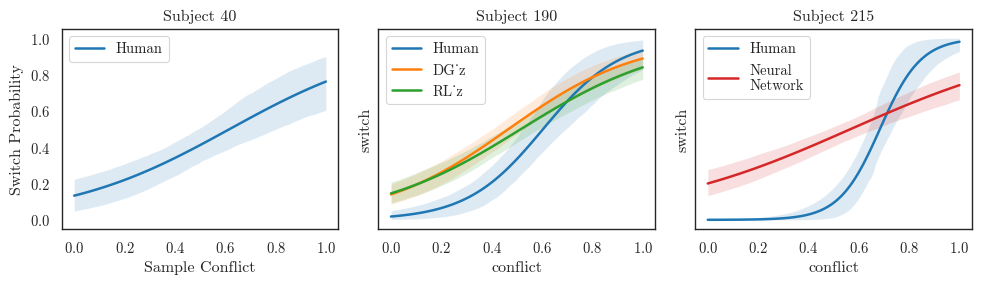

In [201]:
sid1 = sids[0]
sid2 = sids[1]
sid3 = sids[2]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=True, sharex=True)
for mt, model_type in enumerate(combined['type'].unique()):
    sns.regplot(combined.query("sid==@sid1 & type==@model_type"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[mt], ax=axes[0], label=model_type)
    sns.regplot(combined.query("sid==@sid2 & type==@model_type"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[mt], ax=axes[1], label=model_type)
    sns.regplot(combined.query("sid==@sid3 & type==@model_type"), x='conflict', y='switch', scatter=False, logistic=True, color=palette[mt], ax=axes[2], label=model_type)
axes[0].set(ylabel="Switch Probability", xlabel="Sample Conflict", title=f"Subject {sid1}")
axes[1].set(title=f"Subject {sid2}")
axes[2].set(title=f"Subject {sid3}")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.tight_layout()
plt.savefig("plots/switch_vs_beta.jpg", dpi=600)

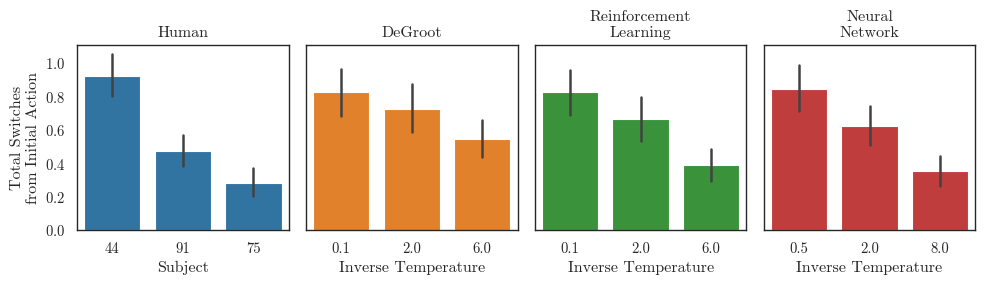

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3), sharex=False, sharey=True)
# A = pd.concat([human, degroot], ignore_index=True)
# B = pd.concat([human, rl], ignore_index=True)
# C = pd.concat([human, nef], ignore_index=True)
# paletteA = [palette[1], palette[1], palette[1]]
# paletteB = [palette[2], palette[2], palette[2]]
# paletteC = [palette[3], palette[3], palette[3]]
# sns.lineplot(A, x='stage', y='switches', hue='beta', ax=axes[0], palette=palette[:4])
# sns.lineplot(B, x='stage', y='switches', hue='beta', ax=axes[1], palette=palette[:4])
# sns.lineplot(C, x='stage', y='switches', hue='beta', ax=axes[2], palette=palette[:4])
sns.barplot(human, x='sid', y='switches', ax=axes[0], color=palette[0], order=sids)
sns.barplot(degroot, x='beta', y='switches', ax=axes[1], color=palette[1])
sns.barplot(rl, x='beta', y='switches', ax=axes[2], color=palette[2])
sns.barplot(nef, x='beta', y='switches', ax=axes[3], color=palette[3])
axes[0].set(xlabel="Subject", title='Human', ylabel='Total Switches\nfrom Initial Action')
axes[1].set(xlabel="Inverse Temperature", title='DeGroot')
axes[2].set(xlabel="Inverse Temperature", title='Reinforcement\nLearning')
axes[3].set(xlabel="Inverse Temperature", title='Neural\nNetwork')
# axes[0].get_legend().remove()
# axes[1].get_legend().remove()
# axes[2].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/switches_vs_beta.jpg", dpi=600)

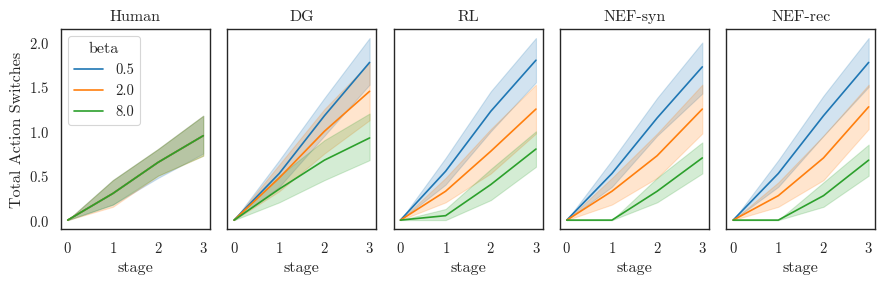

In [10]:
human['beta'] = 'human'
combined = pd.concat(dfs, ignore_index=True)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(9, 3), sharex=True, sharey=True)
sns.lineplot(combined.query("type=='human'"), x='stage', y='switches', hue='beta', ax=axes[0], palette=palette[:3])
sns.lineplot(combined.query("type=='DG_z'"), x='stage', y='switches', hue='beta', ax=axes[1], palette=palette[:3])
sns.lineplot(combined.query("type=='RL_z'"), x='stage', y='switches', hue='beta', ax=axes[2], palette=palette[:3])
sns.lineplot(combined.query("type=='NEF_RL'"), x='stage', y='switches', hue='beta', ax=axes[3], palette=palette[:3])
sns.lineplot(combined.query("type=='NEF_WM'"), x='stage', y='switches', hue='beta', ax=axes[4], palette=palette[:3])
axes[0].set(title='Human', ylabel='Total Action Switches', xticks=[0,1,2,3])
axes[1].set(title='DG')
axes[2].set(title='RL')
axes[3].set(title='NEF-syn')
axes[4].set(title='NEF-rec')
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
axes[4].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/beta_demo_all_model_types.jpg", dpi=600)

### lambda = 1

model type human, z 0.2, alpha 0.2, beta 0.5
model type DG_z, z 0.2, alpha 0.2, beta 0.5
model type RL_z, z 0.2, alpha 0.2, beta 0.5
model type NEF_RL, z 0.2, alpha 0.2, beta 0.5
sid 75, trial 1
sid 75, trial 2
sid 75, trial 3
sid 75, trial 4
sid 75, trial 5
sid 75, trial 6
sid 75, trial 7
sid 75, trial 8
sid 75, trial 9
sid 75, trial 10
sid 75, trial 11
sid 75, trial 12
sid 75, trial 13
sid 75, trial 14
sid 75, trial 15
sid 75, trial 16
sid 75, trial 17
sid 75, trial 18
sid 75, trial 19
sid 75, trial 20
sid 75, trial 21
sid 75, trial 22
sid 75, trial 23
sid 75, trial 24
sid 75, trial 25
sid 75, trial 26
sid 75, trial 27
sid 75, trial 28
sid 75, trial 29
sid 75, trial 30
sid 75, trial 31
sid 75, trial 32
sid 75, trial 33
sid 75, trial 34
sid 75, trial 35
sid 75, trial 36
sid 75, trial 37
sid 75, trial 38
sid 75, trial 39
sid 75, trial 40
model type NEF_WM, z 0.2, alpha 0.2, beta 0.5
sid 75, trial 1
sid 75, trial 2
sid 75, trial 3
sid 75, trial 4
sid 75, trial 5
sid 75, trial 6
sid 75, 

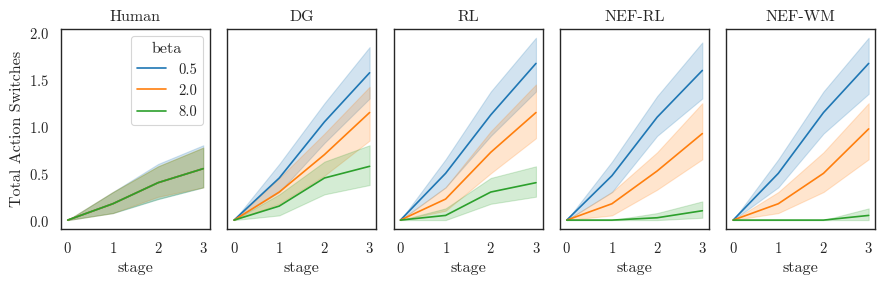

In [4]:
sid = 75
z = 0.2
alpha = 0.2
beta = 5
lambd = 1.0
dfs = []
for beta in [0.5, 2, 8]:
    dfs.append(run_and_get_switches("human", sid, z, alpha, beta, lambd=lambd))
    dfs.append(run_and_get_switches("DG_z", sid, z, alpha, beta, lambd=lambd))
    dfs.append(run_and_get_switches("RL_z", sid, z, alpha, beta, lambd=lambd))
    dfs.append(run_and_get_switches("NEF_RL", sid, z, alpha, beta, lambd=lambd))
    dfs.append(run_and_get_switches("NEF_WM", sid, z, alpha, beta, lambd=lambd))
combined = pd.concat(dfs, ignore_index=True)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(9, 3), sharex=True, sharey=True)
sns.lineplot(combined.query("type=='human'"), x='stage', y='switches', hue='beta', ax=axes[0], palette=palette[:3])
sns.lineplot(combined.query("type=='DG_z'"), x='stage', y='switches', hue='beta', ax=axes[1], palette=palette[:3])
sns.lineplot(combined.query("type=='RL_z'"), x='stage', y='switches', hue='beta', ax=axes[2], palette=palette[:3])
sns.lineplot(combined.query("type=='NEF_RL'"), x='stage', y='switches', hue='beta', ax=axes[3], palette=palette[:3])
sns.lineplot(combined.query("type=='NEF_WM'"), x='stage', y='switches', hue='beta', ax=axes[4], palette=palette[:3])
axes[0].set(title='Human', ylabel='Total Action Switches', xticks=[0,1,2,3])
axes[1].set(title='DG')
axes[2].set(title='RL')
axes[3].set(title='NEF-RL')
axes[4].set(title='NEF-WM')
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
axes[4].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/beta_demo_all_model_types_lambda1.jpg", dpi=600)